##Code for investigating robustness of gao et al VUA Classifcation Model

In [1]:
# mount drive
from google.colab import drive
ROOT = '/content/drive'
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# add repo directory to path
import os
import sys
from os.path import join 
repo_dir = '/content/drive/MyDrive/Repos/metaphor-detection'
if repo_dir not in sys.path:
    sys.path.append(repo_dir)
print(sys.path)

['', '/content', '/env/python', '/usr/lib/python37.zip', '/usr/lib/python3.7', '/usr/lib/python3.7/lib-dynload', '/usr/local/lib/python3.7/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.7/dist-packages/IPython/extensions', '/root/.ipython', '/content/drive/MyDrive/Repos/metaphor-detection']


In [ ]:
# pip install requirements (takes a while)
!cd drive/MyDrive/Repos/metaphor-detection/; pip install -r gao-g-requirements.txt
!pip install --upgrade google-cloud-storage

In [4]:
from core.gao_files.classification.util import get_num_lines, get_vocab, embed_sequence, get_word2idx_idx2word, get_embedding_matrix
from core.gao_files.classification.util  import TextDatasetWithGloveElmoSuffix as TextDataset
from core.gao_files.classification.util  import evaluate
from core.gao_files.classification.model import RNNSequenceClassifier
from core.gao_files.classification.vua_util  import write_predictions_vua_cls, get_performance_VUAverb_test

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader

import csv
import h5py
# import matplotlib
# matplotlib.use('Agg')  # to avoid the error: _tkinter.TclError: no display name and no $DISPLAY environment variable
# matplotlib.use('tkagg') # to display the graph on remote server
import matplotlib.pyplot as plt
import pandas as pd

In [5]:
print("PyTorch version:")
print(torch.__version__)
print("GPU Detected:")
print(torch.cuda.is_available())
using_GPU = torch.cuda.is_available()

PyTorch version:
1.10.0+cu111
GPU Detected:
True


In [6]:
# directories
# to download glove and elmo vectors see: notebooks/Download_large_data.ipynb
data_dir = repo_dir + '/resources/metaphor-in-context/data/'
glove_dir = repo_dir + '/resources/glove/'
elmo_dir = repo_dir + '/resources/elmo/'

### Gao code

In [7]:
"""
1. Data pre-processing
"""
'''
1.1 VUA
get raw dataset as a list:
  Each element is a triple:
    a sentence: string
    a index: int: idx of the focus verb
    a label: int 1 or 0
'''
# header for vua files:
# text_idx, sentence_idx, verb, sentence, verb_idx, label
SENT_IDX = 3
VERB_IDX = 4
LABEL_IDX = 5

raw_train_vua = []
with open(data_dir + 'VUA/VUA_formatted_train.csv', encoding='latin-1') as f:
    lines = csv.reader(f)
    next(lines)
    for line in lines:
        raw_train_vua.append([line[SENT_IDX], int(line[VERB_IDX]), int(line[LABEL_IDX])])

raw_val_vua = []
with open(data_dir+ 'VUA/VUA_formatted_val.csv', encoding='latin-1') as f:
    lines = csv.reader(f)
    next(lines)
    for line in lines:
        raw_val_vua.append([line[SENT_IDX], int(line[VERB_IDX]), int(line[LABEL_IDX])])

raw_test_vua = []
with open(data_dir+ 'VUA/VUA_formatted_test.csv', encoding='latin-1') as f:
    lines = csv.reader(f)
    next(lines)
    for line in lines:
        raw_test_vua.append([line[SENT_IDX], int(line[VERB_IDX]), int(line[LABEL_IDX])])
print('VUA dataset division: ', '\ntrain:', len(raw_train_vua), '\nval:',len(raw_val_vua), '\ntest:',len(raw_test_vua))

VUA dataset division:  
train: 15516 
val: 1724 
test: 5873


In [8]:
"""
2. Data preparation
"""
'''
2. 1
get vocabulary and glove embeddings in raw dataset 
'''
# vocab is a set of words
vocab = get_vocab(raw_train_vua + raw_val_vua + raw_test_vua)
# two dictionaries. <PAD>: 0, <UNK>: 1
word2idx, idx2word = get_word2idx_idx2word(vocab)
# glove_embeddings a nn.Embeddings
glove_embeddings = get_embedding_matrix(glove_dir + 'glove.840B.300d.txt', word2idx, idx2word, normalization=False)
# elmo_embeddings
elmos_train_vua = h5py.File(elmo_dir + 'VUA_train.hdf5', 'r')
elmos_val_vua = h5py.File(elmo_dir + 'VUA_val.hdf5', 'r')
# suffix_embeddings: number of suffix tag is 2, and the suffix embedding dimension is 50
suffix_embeddings = nn.Embedding(2, 50)

vocab size:  18695


100%|██████████| 2196017/2196017 [00:54<00:00, 40118.19it/s]


Number of pre-trained word vectors loaded:  17941
Embeddings mean:  -0.0001772342948243022
Embeddings stdev:  0.37537267804145813


In [9]:
'''
2. 2
embed the datasets
'''
# indices for raw_[train/val]_vua lists
raw_sent_idx = 0
raw_verb_idx = 1
raw_label_idx = 2

embedded_train_vua = [[embed_sequence(example[raw_sent_idx], 
                                      example[raw_verb_idx], 
                                      word2idx, glove_embeddings, elmos_train_vua, suffix_embeddings), 
                       example[raw_label_idx]]
                      for example in raw_train_vua]

embedded_val_vua = [[embed_sequence(example[raw_sent_idx],
                                    example[raw_verb_idx],
                                    word2idx, glove_embeddings, elmos_val_vua, suffix_embeddings), 
                     example[raw_label_idx]]
                    for example in raw_val_vua]

# each row in embedded_[train/val]_vua contains an embedding and a label

In [34]:
import numpy as np
def run_model_once(i, train_dataset_vua, val_dataset_vua, num_epochs = 20):
  print("#"*30)
  print(f"\nRunning model i = {i}\n")
  print("#"*30)

  # set up data loader
  # Data-related hyperparameters
  batch_size = 64
  # Set up a DataLoader for the training, validation, and test dataset
  train_dataloader_vua = DataLoader(dataset=train_dataset_vua, batch_size=batch_size, shuffle=True,
                                    collate_fn=TextDataset.collate_fn)

  val_dataloader_vua = DataLoader(dataset=val_dataset_vua, batch_size=batch_size,
                                  collate_fn=TextDataset.collate_fn)

  """
  3. Model training
  """
  '''
  3. 1 
  set up model, loss criterion, optimizer
  '''
  # Instantiate the model
  rnn_clf = RNNSequenceClassifier(num_classes=2, embedding_dim=300 + 1024 + 50, hidden_size=300, num_layers=1, bidir=True,
                                  dropout1=0.3, dropout2=0.2, dropout3=0.2)
  # Move the model to the GPU if available
  if using_GPU:
      rnn_clf = rnn_clf.cuda()
  # Set up criterion for calculating loss
  nll_criterion = nn.NLLLoss()
  # Set up an optimizer for updating the parameters of the rnn_clf
  rnn_clf_optimizer = optim.SGD(rnn_clf.parameters(), lr=0.01,momentum=0.9)
  # Number of epochs (passes through the dataset) to train the model for.

  training_loss = []
  val_loss = []

  training_f1 = []
  val_f1 = []

  val_accuracy = []
  val_precision = []
  val_recall = []
  val_fus_f1 = []

  # A counter for the number of gradient updates
  num_iter = 0
  for epoch in range(num_epochs):
      print("Starting epoch {}".format(epoch + 1))
      for (example_text, example_lengths, labels) in train_dataloader_vua:
          example_text = Variable(example_text)
          example_lengths = Variable(example_lengths)
          labels = Variable(labels)
          if using_GPU:
              example_text = example_text.cuda()
              example_lengths = example_lengths.cuda()
              labels = labels.cuda()
          # predicted shape: (batch_size, 2)
          predicted = rnn_clf(example_text, example_lengths)
          batch_loss = nll_criterion(predicted, labels)
          rnn_clf_optimizer.zero_grad()
          batch_loss.backward()
          rnn_clf_optimizer.step()
          num_iter += 1
          # Calculate validation and training set loss and accuracy every 200 gradient updates
          if num_iter % 200 == 0:
              avg_eval_loss, eval_accuracy, precision, recall, f1, fus_f1 = evaluate(val_dataloader_vua, rnn_clf,
                                                                                    nll_criterion, using_GPU, print_verbose=False)
              val_loss.append(avg_eval_loss)
              val_f1.append(f1)
              val_accuracy.append(eval_accuracy)
              val_precision.append(precision)
              val_recall.append(recall)
              val_fus_f1.append(fus_f1)

              if num_iter % 1000 == 0:
                print(
                      "Iteration {}. Validation Loss {}. Validation Accuracy {}. Validation Precision {}. Validation Recall {}. Validation F1 {}. Validation class-wise F1 {}.".format(
                          num_iter, avg_eval_loss, eval_accuracy, precision, recall, f1, fus_f1))

  print("Training done!")

  """
  4. test the model
  the following code is for test data of VUA
  """
  '''
  VUA
  '''
  elmos_test_vua = h5py.File(elmo_dir + 'VUA_test.hdf5', 'r')
  embedded_test_vua = [[embed_sequence(example[raw_sent_idx],
                                      example[raw_verb_idx],
                                      word2idx, glove_embeddings, elmos_test_vua, suffix_embeddings), 
                          example[raw_label_idx]]
                      for example in raw_test_vua]

  test_dataset_vua = TextDataset([example[embedding_idx] for example in embedded_test_vua], # embeddings
                                [example[label_idx] for example in embedded_test_vua] # labels
                                )

  test_dataloader_vua = DataLoader(dataset=test_dataset_vua, batch_size=batch_size,
                                  collate_fn=TextDataset.collate_fn)
  cls_test_pred = write_predictions_vua_cls(raw_test_vua, test_dataloader_vua, rnn_clf , using_GPU, data_dir + 'VUA/VUA_formatted_test.csv')
  macro_avg_performance, overall_verb_performance = get_performance_VUAverb_test(data_dir, cls_test_pred)

  macro_F1 = macro_avg_performance[2]
  classification_performance = np.append(overall_verb_performance, macro_F1)
  return list(classification_performance)

In [ ]:
'''
2. 3
set up Dataloader for batching
'''
embedding_idx = 0
label_idx = 1
# Separate the input (embedded_sequence) and labels in the indexed train sets.
train_dataset_vua = TextDataset([example[embedding_idx] for example in embedded_train_vua],
                                [example[label_idx] for example in embedded_train_vua])

val_dataset_vua = TextDataset([example[embedding_idx] for example in embedded_val_vua],
                              [example[label_idx] for example in embedded_val_vua])

In [ ]:
# Run model a bunch of times
number_times_to_run = 10
num_epochs = 10 #20
average_metrics = [['P', 'R', 'F1', 'Acc', 'MaF1']]
for test_i in range(number_times_to_run):
  average_metrics.append(run_model_once(test_i, train_dataset_vua, val_dataset_vua, num_epochs=num_epochs))

In [52]:
average_metrics_df =  pd.DataFrame(average_metrics[1:], columns = average_metrics[0])
average_metrics_df 

,P,R,F1,Acc,MaF1
0,75.287356,52.072686,61.564283,80.504001,56.362457
1,67.628993,62.521295,64.974919,79.788864,60.358038
2,71.841155,56.501988,63.254927,80.316704,59.202261
3,74.530612,51.845542,61.152043,80.248595,56.398371
4,76.764706,44.463373,56.310680,79.312106,52.388014
5,72.648903,52.640545,61.047086,79.856973,55.558423
6,73.712529,54.457694,62.638798,80.521028,57.262419
7,68.915344,59.170926,63.672472,79.754810,60.241636
8,74.870466,49.233390,59.403905,79.822918,54.135022
9,73.632653,51.220897,60.415271,79.874000,55.813961


In [53]:
output_dir = "/content/drive/MyDrive/metaphor-detection-output/"
file_name = "vua_cls_classification_performance_epochs-{}.csv".format(num_epochs)
average_metrics_df.to_csv(output_dir+file_name, index=False)

## Output compared to Gao

**Precision:** 53.4

**Recall:** 65.6

**F1:** 58.9

**Accuracy:** 69.1

**MaF1:** 53.4

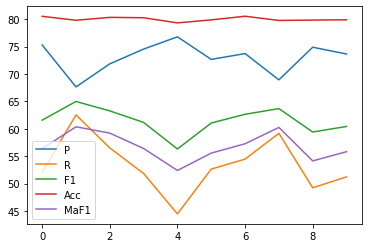

In [55]:
# 10 epochs per run
average_metrics_df.plot.line()

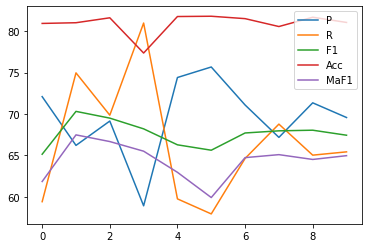

In [58]:
# 20 epochs
average_metrics_df_20 = pd.read_csv(output_dir+"vua_cls_classification_performance_epochs-{}.csv".format(20))
average_metrics_df_20.plot.line()